## Could we predict Cryptocurrencies? 
<p>Since the launch of Bitcoin in 2008, hundreds of similar projects based on the blockchain technology have emerged. We call these cryptocurrencies (also coins or cryptos in the Internet slang). Some are extremely valuable nowadays, and others may have the potential to become extremely valuable in the future<sup>1</sup>. In fact, the 6th of December of 2017 Bitcoin has a market capitalization above $200 billion. </p>
<p>
<p>That said, let's get to business. As a first task, we will load the current data from the API and display it in the output.</p>

## Contents:
   * [Getting Cryptocurrencies info using API Queries](#getting_cur)
   * [Cryptocurrencies evolution](#evo)
   * [Cryptocurrencies correlation](#corr)
   * [Coins returns (percent of change)](#return)
   * [Creation of equal weight index](#index)
   * [Covariance using the created index](#cov)
   * [Checking stationarity, seasonality, differencing, autocorrelation (to be continued)](#cov)
       * [Stationarity](#cov)
       * [Transformation](#cov)
       * [Differencing](#cov)
       * [Autocorrelation](#cov)
   * [Forecasting using ARIMA model (to be continued)](#cov)
   * [Forecasting using deep learning (to be continued)](#cov)
<p>Let's begin by importing libraries.</p>

In [25]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.special import betainc 

from crycompare import price as p
from crycompare import history as h
from cryptocompy import top as t

%matplotlib inline
sns.set(rc={"figure.figsize": (20,10), "axes.titlesize" : 18, "axes.labelsize" : 12, 
            "xtick.labelsize" : 14, "ytick.labelsize" : 14 }, 
        palette=sns.color_palette("Blues_r", 20))

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We need to specify studied coins and periods

In [115]:
# Parameters
coins = ['BTC','LTC','ETH','IOT', 'XMR', 'NEO', 'DASH', 'OMG']  # coins
from_date='2018-01-01'   # from
to_date='2018-06-30'  # to
k = 20  # number of top currencies to get

## Getting top currencies info <a class="anchor" id="getting_cur"></a>

In [82]:
# function to get k top currencies from the API
def get_k_top_currency(from_date,to_date,k):
    top_coins_list = t.get_top_coins('USD', limit=k)
    top_coins = [x['SYMBOL'] for x in top_coins_list]
    print('Top ',k,' cryptocurrencies are: ',top_coins)
    dict_df = {}
    for coin in top_coins:
        history = h.histo_day(coin,'USD',all_data=True)
        if history:
            df_history = pd.DataFrame(history)
            df_history['symbol']=coin
            df_history['time'] = pd.to_datetime(df_history['time'],unit='s')
            df_history.index = df_history['time']
            df_history.drop(['time','volumefrom','volumeto'],axis=1,inplace=True)
            dict_df[coin] = df_history
    df_top = pd.concat(dict_df.values(), axis=0)
    df_top = df_top.loc[from_date:to_date,:]
    return df_top

from datetime import date, timedelta
day_from = (date.today() - timedelta(days=3)).strftime('%d-%m-%y')
day_to = date.today().strftime('%d-%m-%y')
df_top = get_k_top_currency(day_from,day_to,k)

Top  20  cryptocurrencies are:  ['BTC', 'ETH', 'EOS', 'BCH', 'LTC', 'ETC', 'XRP', 'NEO', 'IOT', 'XMR', 'ETP', 'ZEC', 'OMG', 'DASH', 'ANS', 'ADA', 'XLM', 'USDT', 'BTG', 'TRX', 'EUR']


Let's display here the top k cryptocurrencies in the market in the current days:

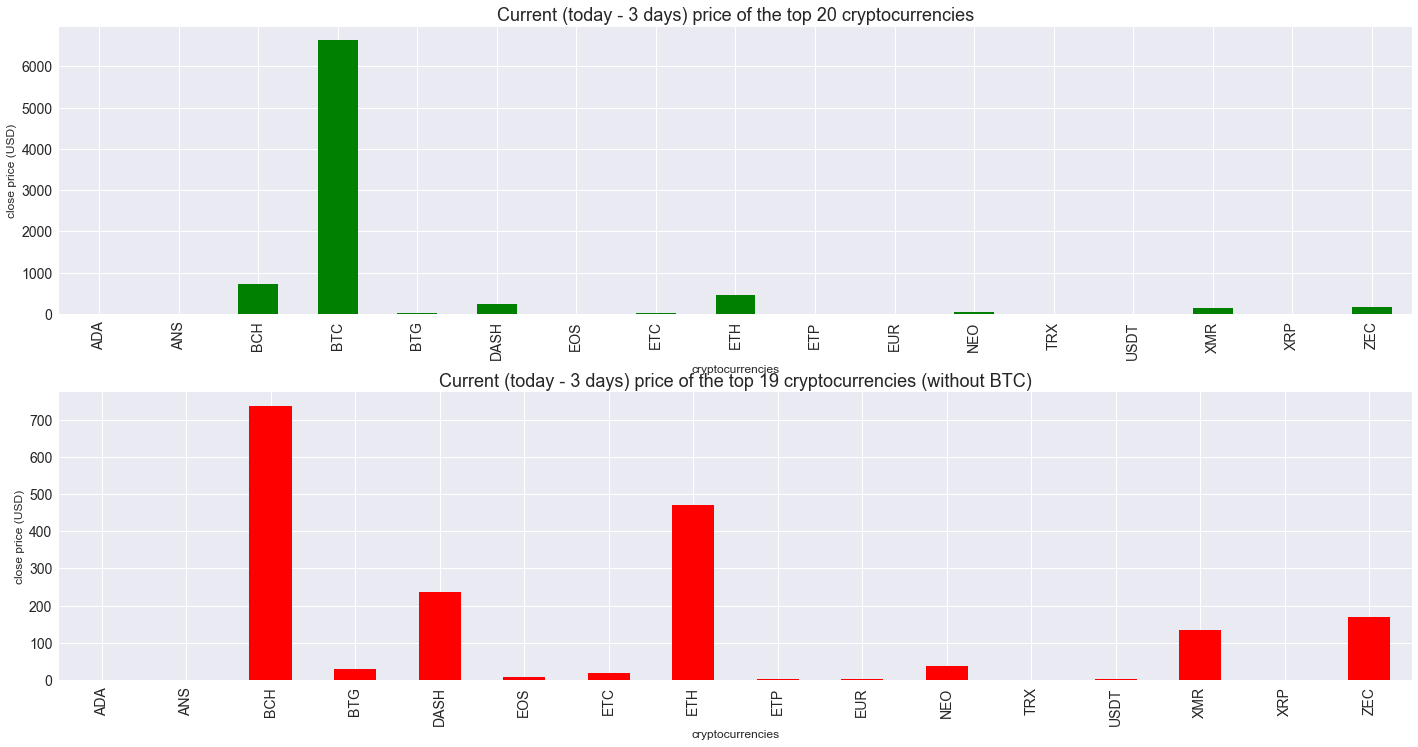

In [94]:
df_plot = df_top.groupby('symbol').close.mean()
df_plot_wtBTC = df_plot.reset_index()
df_plot_wtBTC = df_plot_wtBTC[df_plot_wtBTC['symbol']!='BTC'].set_index('symbol')
plt.figure()
plt.subplot(2,1,1)
plt.tight_layout()
df_plot.plot(kind='bar',color='g')
plt.xlabel('cryptocurrencies')
plt.ylabel('close price (USD)')
plt.title('Current (today - 3 days) closing price of the top ' + str(k) +  ' cryptocurrencies')
plt.subplot(2,1,2)
plt.tight_layout()
df_plot_wtBTC.close.plot(kind='bar',color='r')
plt.xlabel('cryptocurrencies')
plt.ylabel('close price (USD)')
plt.title('Current (today - 3 days) closing price of the top ' + str(k-1) +  ' cryptocurrencies (without BTC)')
plt.show()

## Coins evolution <a class="anchor" id="evo"></a>

In [116]:
# function to get coins info from the API
def get_currency_info(coins,from_date,to_date):
    dict_df = {}
    for coin in coins:
        history = h.histo_day(coin,'USD',all_data=True)
        if history:
            df_history = pd.DataFrame(history)
            df_history['symbol']=coin
            df_history['time'] = pd.to_datetime(df_history['time'],unit='s')
            df_history.index = df_history['time']
            df_history.drop(['time','volumefrom','volumeto'],axis=1,inplace=True)
            dict_df[coin] = df_history
    df_crypto = pd.concat(dict_df.values(), axis=0)
    df_crypto = df_crypto.loc[from_date:to_date,:]
    return df_crypto

In [117]:
df = get_currency_info(coins,from_date,to_date)

In [103]:
# function to plot coins historical evolution
from itertools import cycle, islice
def plot_evolution_coin(variable,coins):
    fig, ax = plt.subplots()
    my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(df)))
    for i, coin in enumerate(coins):
        df[df['symbol']==coin][variable].ffill().plot(ax=ax, legend=True,color=my_colors[i])
    plt.legend(coins)
    plt.ylabel('(USD)')
    plt.xlabel('Time')
    plt.title('The evolution of the closing price of the cryptocurrencies during the chosen period')

and without BTC


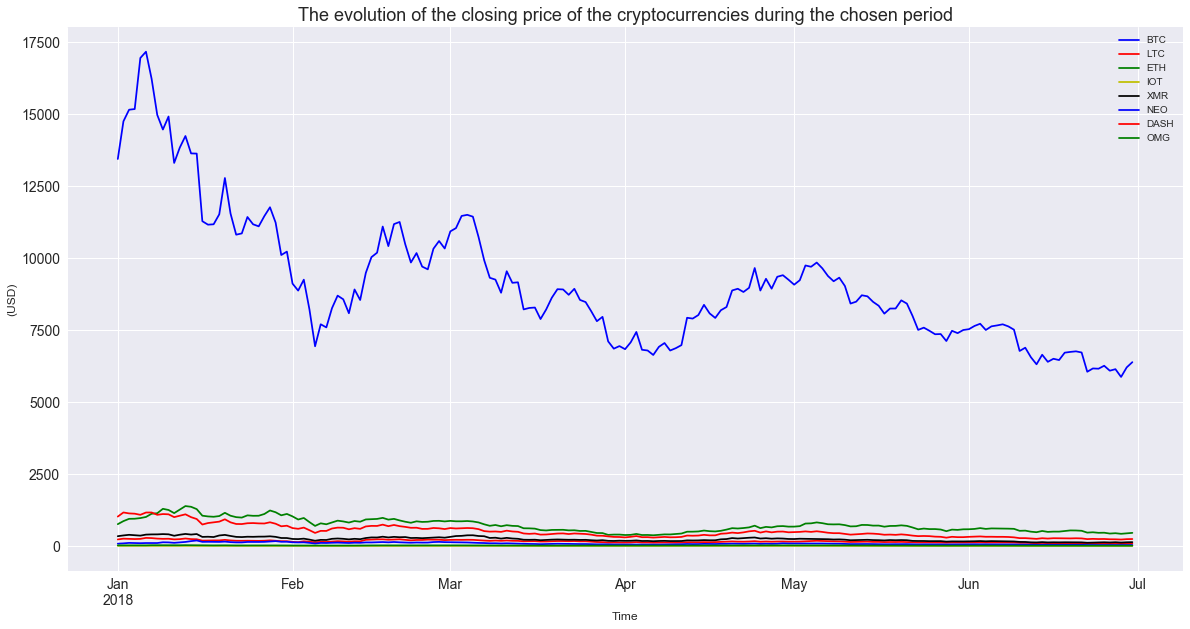

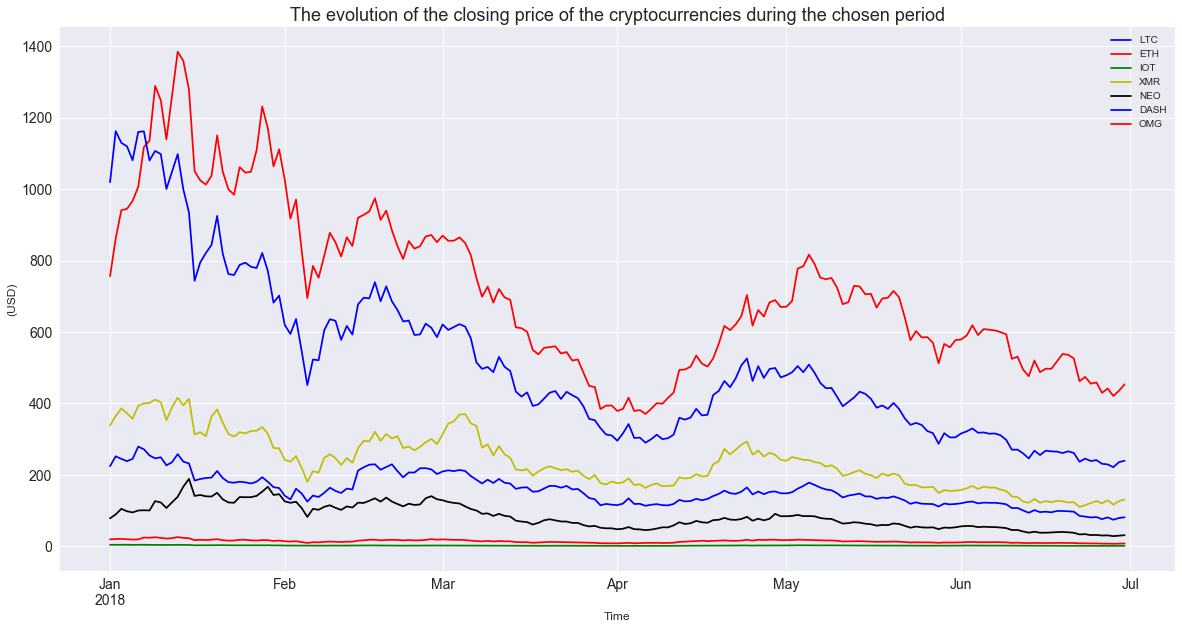

In [104]:
plot_evolution_coin("close",coins)
if 'BTC' in coins:
    coins2 = [i for i in coins if i!='BTC']
    print('and without BTC')
    plot_evolution_coin("close",coins2)    

## Cryptocurrencies Correlation <a class="anchor" id="corr"></a>

The matrices above show Pearson correlations and p-values computed from returns of daily prices over the chosen period.
P-values quantify the statistical significance of a result. In the case of correlations, the p-values can be interpreted as follows:
* p-value ≤ 0.05: the correlation is statistically significant and you can conclude that the correlation is different from 0.
* p-value > 0.05: the correlation is not statistically significant and you cannot conclude that the correlation is different from 0.

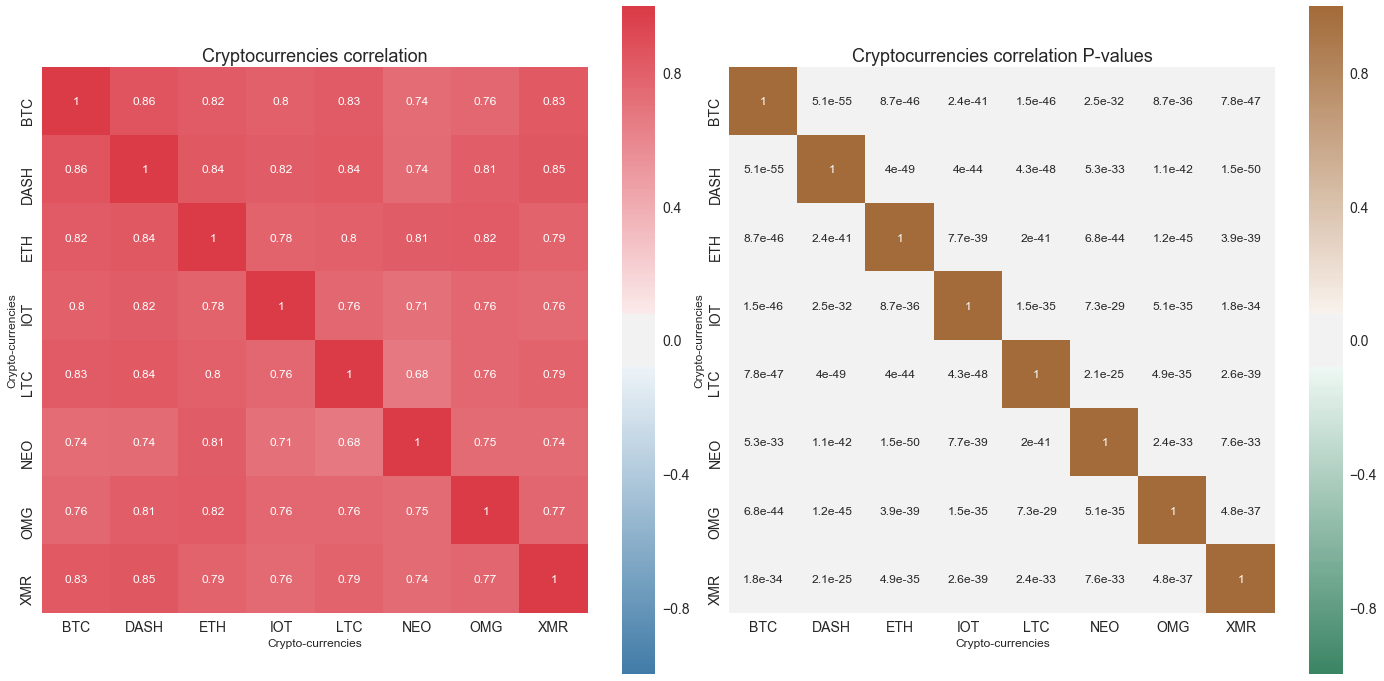

In [44]:
# function to plot coins inbetween correlation
def corrcoef(matrix):
    r = np.corrcoef(matrix)
    rf = r[np.triu_indices(r.shape[0], 1)]
    df = matrix.shape[1] - 2
    ts = rf * rf * (df / (1 - rf * rf))
    pf = betainc(0.5 * df, 0.5, df / (df + ts))
    p = np.zeros(shape=r.shape)
    p[np.triu_indices(p.shape[0], 1)] = pf
    p[np.tril_indices(p.shape[0], -1)] = pf
    p[np.diag_indices(p.shape[0])] = np.ones(p.shape[0])
    return r, p

def plot_corr(variable):
    df_p = df[[variable,'symbol']].pivot(columns='symbol',values=variable)
    df_p = df_p.pct_change().dropna()
    matrix= df_p.T.as_matrix()
    r,p = corrcoef(matrix)
    df_corr = pd.DataFrame(r,columns=df_p.columns,index=df_p.columns)
    df_pvalue = pd.DataFrame(p,columns=df_p.columns,index=df_p.columns)
    cmap1 = sns.diverging_palette(240, 10,sep=20, as_cmap=True)
    cmap2 = sns.diverging_palette(150, 40,sep=20, as_cmap=True)
    plt.figure()
    plt.subplot(1,2,1)
    plt.tight_layout()
    sns.heatmap(df_corr, 
        xticklabels=df_corr.columns.values,
        yticklabels=df_corr.columns.values, 
        cmap=cmap1, vmin=-1, vmax=1, annot=True, square=True)
    plt.title('Cryptocurrencies correlation')
    plt.xlabel("Crypto-currencies")
    plt.ylabel("Crypto-currencies")
    plt.subplot(1,2,2)
    plt.tight_layout()
    sns.heatmap(df_pvalue, 
        xticklabels=df_pvalue.columns.values,
        yticklabels=df_pvalue.columns.values, 
        cmap=cmap2, vmin=-1, vmax=1, annot=True, square=True)
    plt.title('Cryptocurrencies correlation P-values')
    plt.xlabel("Crypto-currencies")
    plt.ylabel("Crypto-currencies")
    
plot_corr("close")

Cryptocurrency correlation coefficients are interesting tools when assessing crypto investment.
Price differentials enable extracting an advantage in the market. For example, the imperfect correlation between two cryptocurrencies allow more diversification and marginally lower risk.

## Coins returns (percent of change) <a class="anchor" id="return"></a>

It is also interesting the check the volatility of our list of cryptocurrencies over the chosen period

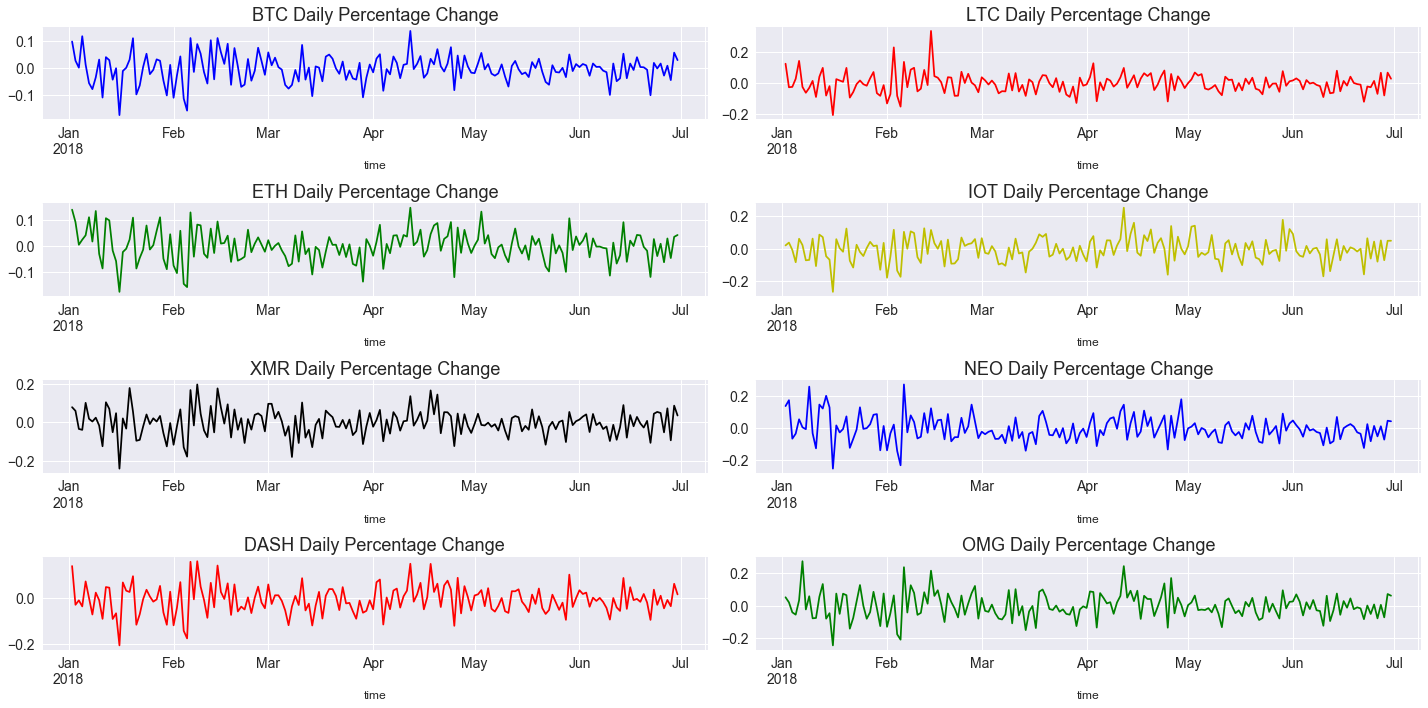

In [113]:
from itertools import cycle, islice
my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(df)))
def pct_change_plot(coin, variable,i):
    df_pct_change = df[[variable,'symbol']].pivot(columns='symbol',values=variable)[coin]\
            .pct_change().plot(title=coin + ' Daily Percentage Change',color=my_colors[i])
plt.figure()
sz = len(coins)
for i,coin in enumerate(coins):
    plt.tight_layout()
    plt.subplot(sz//2,2,i+1)
    pct_change_plot(coin, 'close',i) 

## Creation of an index <a class="anchor" id="index"></a>

Many of the largest and most well-known market indices are either market cap-weighted or price-weighted. Market cap-weighted indices, such as the Standard & Poor's (S&P) 500, give greater weight to the biggest companies according to market capitalization. Price-weighted indices, such as the Dow Jones Industrial Average (DJIA), give larger weightings to stocks with higher stock prices.
The concept of equally weighted portfolios has gained interest due to historical performance and the emergence of several exchange-traded fund options.
We use here equal weight index to gives the same "weight" to each top cryptocurrency in the chosen portfolio. We begin by creating this index.

Top  20  cryptocurrencies are:  ['BTC', 'ETH', 'EOS', 'BCH', 'LTC', 'ETC', 'XRP', 'NEO', 'IOT', 'XMR', 'ETP', 'ZEC', 'OMG', 'DASH', 'ANS', 'ADA', 'XLM', 'BTG', 'USDT', 'TRX', 'ZRX']


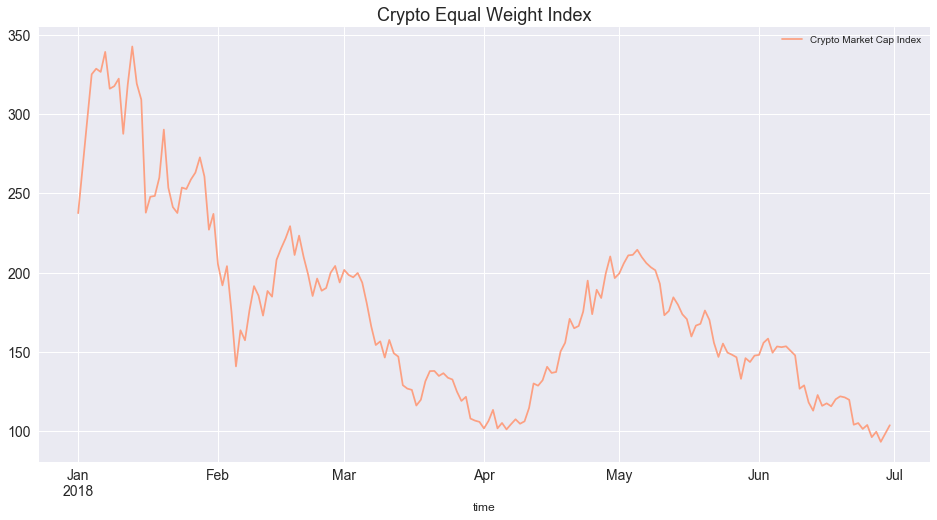

In [118]:
# we create an index using a start date and the k top coins
df_k_top = get_k_top_currency(from_date,to_date,k) # getting k top cryptocurrencies
def create_index(start_date):
    n = len(coins)
    start_index_currencies_df = df_k_top.loc[start_date,:]
    start_index_currencies_df['eq_index_holdings'] = 100 / n / start_index_currencies_df['close']
    # Add eq_index_holdings column to index_currencies_df
    index_currencies_df = pd.merge(left=df_k_top.loc[start_date:,:],right=start_index_currencies_df[['symbol', 'eq_index_holdings']]\
                                   , how='left', left_on='symbol', right_on='symbol')
    index_currencies_df.index = df_k_top.loc[start_date:,:].index
    # Calculate the value for each date/Currency
    index_currencies_df['eq_index_holdings_value'] = index_currencies_df['eq_index_holdings']*index_currencies_df['close']
    # Build index
    cryptoEq_index_df = index_currencies_df.groupby(index_currencies_df.index)['eq_index_holdings_value'].sum()
    with sns.color_palette("Reds", 2):
        ax = cryptoEq_index_df.plot(figsize=(16,8), title='Crypto Equal Weight Index', label='Crypto Market Cap Index', legend=True)
    return cryptoEq_index_df
cryptoEq_index = create_index(from_date)

## Covariance using the created index <a class="anchor" id="cov"></a>

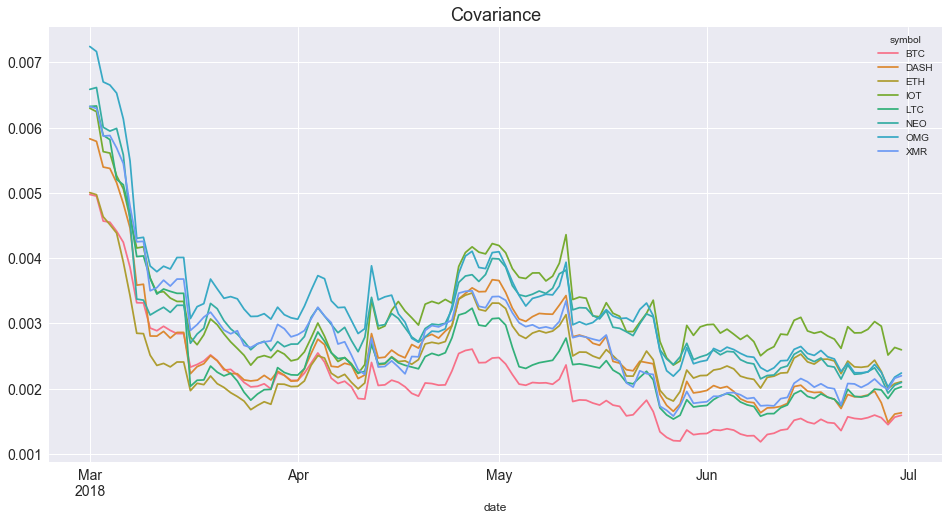

In [12]:
cryptoEq_index_df = cryptoEq_index.copy().reset_index()
cryptoEq_index_df.columns = ["date","eq_index_value"]

# calculate the market variance based on the Crypto20 Equal Weight Index
cryptoEq_index_df['pct_change'] = cryptoEq_index_df['eq_index_value'].pct_change()
cryptoEq_index_df['ma_30'] = cryptoEq_index_df['pct_change'].rolling(window=30).mean()
cryptoEq_index_df['deviation'] = cryptoEq_index_df['pct_change'] - cryptoEq_index_df['ma_30']
cryptoEq_index_df['variance'] = cryptoEq_index_df['deviation']**2 / 30

# calculate the covariance between the return of the crypto and the market return
df_k_top_merge = df.copy().reset_index()
df_k_top_merge.columns = ['date', 'close', 'high', 'low', 'open', 'symbol']
df_k_top_merge['pct_change'] = df_k_top_merge['close'].pct_change()
df_k_top_merge['ma_30'] = df_k_top_merge['pct_change'].rolling(window=30).mean()
df_k_top_merge['deviation'] = df_k_top_merge['pct_change'] - df_k_top_merge['ma_30']
df_k_top_merge['variance'] = df_k_top_merge['deviation']**2 / 30

# covariance
df_k_top_merge =  pd.merge(left=df_k_top_merge,right=cryptoEq_index_df[['date', 'pct_change', 'ma_30', 'deviation']], how='left', left_on='date', right_on='date')
df_k_top_merge['product'] = df_k_top_merge['deviation_x']*df_k_top_merge['deviation_y']
df_k_top_merge['covariance'] = df_k_top_merge['product'].rolling(window=30).sum()/29

# Plot the covariance

top_currencies_cov_df = df_k_top_merge.pivot(index='date', columns='symbol', values='covariance')

with sns.color_palette("husl", 10):
    top_currencies_cov_df.plot(figsize=(16,8), title='Covariance')